#1. Setup SLEAP and Necessary Libraries

In [1]:
# This should take care of all the dependencies on colab:
# !pip uninstall -y opencv-python opencv-contrib-python && pip install sleap

In [ ]:
!pip uninstall -qqq -y opencv-python opencv-contrib-python
!pip install -qqq "sleap[pypi]>=1.3.3"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 904.1/904.1 kB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.0/134.0 kB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 6.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.8/16.8 MB 34.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.5/60.5 MB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 34.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 228.9/228.9 kB 23.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.5/93.5 kB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 214.3/214.3 kB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━

In [ ]:
import sleap
sleap.disable_preallocation()  # This initializes the GPU and prevents TensorFlow from filling the entire GPU memory
sleap.versions()
sleap.system_summary()

In [ ]:
import pandas as pd
import time
import math
import matplotlib.pyplot as plt
import matplotlib

In [ ]:
from sklearn import metrics
import numpy as np

In [ ]:
# Say, "the default sans-serif font is COMIC SANS"
matplotlib.rcParams['font.sans-serif'] = "Arial"

# Then, "ALWAYS use sans-serif fonts"
matplotlib.rcParams['font.family'] = "sans-serif"

In [ ]:
# Suppress annoying warnings!
import logging
logging.getLogger("matplotlib.font_manager").setLevel(logging.ERROR)

#2. Setup Data

In [ ]:
%cd ..
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
%cd /content/gdrive/Othercomputers/My\ PC/PhD_UOM/General/BSBRL/Projects/Motorized_Commutator/SLEAP
!pwd
# %cd content/gdrive/
!ls

In [ ]:
# Creates a symbolic link for the model comparison folder
!ln -s /content/gdrive/Othercomputers/My\ PC/PhD_UOM/General/BSBRL/Projects/Motorized_Commutator/Paper/Model_Comparison /MComp

In [ ]:
!ls /MComp

In [ ]:
# Setup data paths
# Some accronym definitions:
# GT = Ground Truth

# Ground truth data path
GT_APA = "/MComp/Ground_Truth/APA_Ground_Truth.csv"
GT_BM = "/MComp/Ground_Truth/BarnesMaze_Ground_Truth.csv"
GT_OF = "/MComp/Ground_Truth/OpenField_Ground_Truth.csv"

# Load the csv data
GT_APA_Data = pd.read_csv(GT_APA, header=None)
GT_BM_Data = pd.read_csv(GT_BM, header=None)
GT_OF_Data = pd.read_csv(GT_OF, header=None)

# SLEAP Exported Models
SLEAP_APA = "/MComp/Exported_Models/SLEAP_APA_240213.zip"
SLEAP_BM = "/MComp/Exported_Models/SLEAP_BM_240213.zip"
SLEAP_OF = "/MComp/Exported_Models/SLEAP_OF_240214.zip"

# Behavior videos
APA_Video = sleap.load_video("/MComp/Videos/APA.mp4")
BM_Video = sleap.load_video("/MComp/Videos/Barnes_Maze.mp4")
OF_Video = sleap.load_video("/MComp/Videos/Open_Field.avi")

#3. Interactive Inference

In [ ]:
manual_data_path = "/sleap_drive/Data/outDataPrep.csv"

manual_data = pd.read_csv(manual_data_path)
frames_toeval = manual_data.shape[0]

print("Manual data imported ...")
print("Number of frames to evaluate: ", frames_toeval)
print("")

Manual data imported ...
Number of frames to evaluate:  50



In [ ]:
# Check what data looks like
# manual_data['x1'][:5]
manual_data.head(5)

,x1,y1,x2,y2,frame
0,340.083333,232.250000,302.250000,265.083333,83
1,364.190625,372.492708,317.107292,358.838542,878
2,335.882407,359.654630,305.123148,314.075000,1056
3,357.344792,355.078125,312.821875,335.701042,1344
4,346.898438,300.635938,301.617188,278.782812,1495


In [ ]:
# Initialize the sleap model and video file
predictor = sleap.load_model("/sleap_drive/Data/model_N31.zip", batch_size=16)

video = sleap.load_video("/sleap_drive/Data/Kapil_Video_Clipping_01.mp4")
video.shape, video.dtype

((17706, 540, 960, 3), dtype('uint8'))

In [ ]:
# Load frames to a numpy array.
imgs = video[manual_data['frame'][5]]
print(f"imgs.shape: {imgs.shape}")

predictions = predictor.inference_model.predict(imgs, numpy=True)
predictions

imgs.shape: (1, 540, 960, 3)


{'instance_peaks': array([[[[372.28787, 385.92807],
          [327.88657, 359.77365]]]], dtype=float32),
 'instance_peak_vals': array([[[0.86450464, 0.9783337 ]]], dtype=float32)}

In [ ]:
predictions['instance_peaks'][0][0][0]

array([372.28787, 385.92807], dtype=float32)

In [ ]:
predictions['instance_peaks'][0][0][1]

array([327.88657, 359.77365], dtype=float32)

In [ ]:
predictions['instance_peak_vals'][0][0]

array([0.86450464, 0.9783337 ], dtype=float32)

In [ ]:
def check_datatype(mouth_temp, neck_temp):
  # Check variables
  chk_mt_0 = (str(mouth_temp[0].dtype) == 'float32')
  chk_mt_1 = (str(mouth_temp[1].dtype) == 'float32')
  chk_nk_0 = (str(neck_temp[0].dtype) == 'float32')
  chk_nk_1 = (str(neck_temp[1].dtype) == 'float32')

  return chk_nk_0 and chk_nk_1 and chk_mt_0 and chk_mt_1

In [ ]:
def check_ind_datatype(body):
  # Check variables
  chk_body_0 = (str(body[0].dtype) == 'float32')
  chk_body_1 = (str(body[1].dtype) == 'float32')

  return chk_body_0 and chk_body_1

In [ ]:
def check_ind_data(body):
  # Check variables
  chk_body_0 = (str(body[0]) != 'nan')
  chk_body_1 = (str(body[1]) != 'nan')

  return chk_body_0 and chk_body_1

In [ ]:
# Loop through frames in csv
for i in range(manual_data.shape[0]):

  img = video[manual_data['frame'][i]]
  prediction = predictor.inference_model.predict(img, numpy=True)

  print("Counter:		", i)
  print("frame id:	", manual_data['frame'][i])
  print('Head: ', prediction['instance_peaks'][0][0][0], ' Accuracy: ', prediction['instance_peak_vals'][0][0][0])
  print('Tail: ', prediction['instance_peaks'][0][0][1], ' Accuracy: ', prediction['instance_peak_vals'][0][0][1])
  print(check_ind_data(prediction['instance_peaks'][0][0][0]))
  print("")

Counter:		 0
frame id:	 83
Head:  [nan nan]  Accuracy:  0.07366826
Tail:  [300.31265 263.77563]  Accuracy:  0.7768413
False

Counter:		 1
frame id:	 878
Head:  [363.72928 371.78214]  Accuracy:  0.68831664
Tail:  [314.22253 357.93546]  Accuracy:  0.70789486
True

Counter:		 2
frame id:	 1056
Head:  [332.00632 359.87317]  Accuracy:  0.8990844
Tail:  [302.05975 312.1553 ]  Accuracy:  0.98075885
True

Counter:		 3
frame id:	 1344
Head:  [356.2544  352.32434]  Accuracy:  0.84337753
Tail:  [310.2375  332.06592]  Accuracy:  1.040844
True

Counter:		 4
frame id:	 1495
Head:  [347.8268  300.26135]  Accuracy:  0.4134351
Tail:  [301.67035 276.05542]  Accuracy:  0.73953825
True

Counter:		 5
frame id:	 1704
Head:  [372.28787 385.92807]  Accuracy:  0.86450464
Tail:  [327.88657 359.77365]  Accuracy:  0.9783337
True

Counter:		 6
frame id:	 1889
Head:  [334.146   339.84805]  Accuracy:  0.95592266
Tail:  [302.2441  282.12268]  Accuracy:  0.870151
True

Counter:		 7
frame id:	 1965
Head:  [362.22214 38

In [ ]:
head_temp = prediction['instance_peaks'][0][0][0]      # mouth_temp[:2]
neck_temp = prediction['instance_peaks'][0][0][1]      # neck_temp[:2]

print(head_temp)
print(neck_temp)

check_datatype(head_temp, neck_temp)

[507.81854 377.93805]
[463.99194 414.07294]


True

# Inference Time and Accuracy Comp

In [23]:
model_name = "SLEAP-APA"

# Run through each bevaior one at a time
manual_data = GT_APA_Data
video = APA_Video

# Initialize the sleap model and video file
predictor = sleap.load_model(SLEAP_APA, batch_size=16)

In [26]:
# Counter variable to keep track of frame count
counter = 0

# Variables to hold the different classifications
fp_head = 0
fn_head = 0
tp_head = 0
tn_head = 0
fp_tail = 0
fn_tail = 0
tp_tail = 0
tn_tail = 0
actual_head = []
predicted_head = []
actual_tail = []
predicted_tail = []

invalid_head = 0
invalid_tail = 0

invalid_head_frames = []
invalid_tail_frames = []

inference_time = []
frames_inferenced = []

# Thresholds
accuracy_threshold = 95   # 95
x_threshold = 10      # 10
y_threshold = 10      # 10

# Global time variable
start_time = 0
end_time = 0
inference_time = []

In [25]:
manual_data.columns

Int64Index([0, 1, 2, 3, 4], dtype='int64')

In [28]:
# Loop through frames in csv
for i in range(manual_data.shape[0]):

  # Determine frame to read from the annotated manual data
  img = video[manual_data[4][i]]

  start_time = time.time()

  # Get inference from an image frame
  prediction = predictor.inference_model.predict(img, numpy=True)

  end_time = time.time()

  frame_id = manual_data[4][i]

  # Get inference duration
  time_diff = end_time - start_time
  inference_time.append(time_diff)
  print("Counter:		", i)
  print("frame id:	", frame_id)
  print("Inference time: %s seconds" % time_diff)
  print("Image Pose:	", prediction)
  print("")

  auto_head_x = prediction['instance_peaks'][0][0][0][0]
  auto_head_y = prediction['instance_peaks'][0][0][0][1]

  auto_tail_x = prediction['instance_peaks'][0][0][1][0]
  auto_tail_y = prediction['instance_peaks'][0][0][1][1]

  auto_head_accuracy = prediction['instance_peak_vals'][0][0][0] * 100
  auto_tail_accuracy = prediction['instance_peak_vals'][0][0][1] * 100

  manual_head_x = manual_data[0][i]
  manual_head_y = manual_data[1][i]
  manual_tail_x = manual_data[2][i]
  manual_tail_y = manual_data[3][i]

  # TEST
  # Print out the differences between manual and automatic labels
  print("HEAD X DIFFERENCE:		", auto_head_x - manual_head_x)
  print("HEAD Y DIFFERENCE:		", auto_head_y - manual_head_y)
  print("TAIL X DIFFERENCE:		", auto_tail_x - manual_tail_x)
  print("TAIL Y DIFFERENCE:		", auto_tail_y - manual_tail_y)
  print("\n\n")

  # """
  # HEAD
  if not math.isnan(auto_head_x) and not math.isnan(auto_head_y):
    if abs(auto_head_x - manual_head_x) > x_threshold or abs(auto_head_y - manual_head_y) > y_threshold:
      if auto_head_accuracy >= accuracy_threshold:
        fp_head = fp_head + 1
        actual_head.append(0)
        predicted_head.append(1)
      else:
        tn_head = tn_head + 1
        actual_head.append(1)
        predicted_head.append(0)
    else:
      if auto_head_accuracy >= accuracy_threshold:
        tp_head = tp_head + 1
        actual_head.append(1)
        predicted_head.append(1)
      else:
        fn_head = fn_head + 1
        actual_head.append(0)
        predicted_head.append(0)
  else:
    invalid_head += 1
    invalid_head_frames.append(frame_id)

  # TAIL
  if not math.isnan(auto_tail_x) and not math.isnan(auto_tail_y):
    if abs(auto_tail_x - manual_tail_x) > x_threshold or abs(auto_tail_y - manual_tail_y) > y_threshold:
      if auto_tail_accuracy >= accuracy_threshold:
        fp_tail = fp_tail + 1
        actual_tail.append(0)
        predicted_tail.append(1)
      else:
        tn_tail = tn_tail + 1
        actual_tail.append(1)
        predicted_tail.append(0)
    else:
      if auto_tail_accuracy >= accuracy_threshold:
        tp_tail = tp_tail + 1
        actual_tail.append(1)
        predicted_tail.append(1)
      else:
        fn_tail = fn_tail + 1
        actual_tail.append(0)
        predicted_tail.append(0)
  else:
    invalid_tail += 1
    invalid_tail_frames.append(frame_id)

  # """

Counter:		 0
frame id:	 84
Inference time: 0.6908352375030518 seconds
Image Pose:	 {'instance_peaks': array([[[[328.14157, 474.0119 ],
         [293.7689 , 440.17932]]]], dtype=float32), 'instance_peak_vals': array([[[0.971854 , 0.9972429]]], dtype=float32)}

HEAD X DIFFERENCE:		 -3.713984510634134
HEAD Y DIFFERENCE:		 -1.8992092556422335
TAIL X DIFFERENCE:		 -1.1088873969186466
TAIL Y DIFFERENCE:		 -2.3095675998264937



Counter:		 1
frame id:	 1363
Inference time: 0.5315582752227783 seconds
Image Pose:	 {'instance_peaks': array([[[[366.17664, 471.99734],
         [320.17126, 441.93393]]]], dtype=float32), 'instance_peak_vals': array([[[1.0748628, 0.7303869]]], dtype=float32)}

HEAD X DIFFERENCE:		 -2.302993887442483
HEAD Y DIFFERENCE:		 -1.7785809552228784
TAIL X DIFFERENCE:		 -2.371327944155496
TAIL Y DIFFERENCE:		 -3.167922408492643



Counter:		 2
frame id:	 1404
Inference time: 0.5335612297058105 seconds
Image Pose:	 {'instance_peaks': array([[[[335.90277, 461.77252],
         [3

In [ ]:
print("Final predicted label classes for head:")
print("1  (true positive): ", tp_head)
print("2  (true negative): ", tn_head)
print("3 (false positive): ", fp_head)
print("4 (false negative): ", fn_head)
print("        ")
print("Final predicted label classes for tail:")
print("1  (true positive): ", tp_tail)
print("2  (true negative): ", tn_tail)
print("3 (false positive): ", fp_tail)
print("4 (false negative): ", fn_tail)
print("        ")
print("Invalid head: ", invalid_head, ",  Frames: ", invalid_head_frames)
print("Invalid tail: ", invalid_tail, ",  Frames: ", invalid_tail_frames)
print("        ")
print("Actual head: ", actual_head)
print("Predicted head: ", predicted_head)
print("        ")
print("Actual tail: ", actual_tail)
print("Predicted tail: ", predicted_tail)
print("        ")
print("Inference times: ", inference_time)

In [ ]:
# Plot final confusion matrices
# Initialize figure with a subplot
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
axis_fontsize = 12
title_fontsize = 16

ax[0].set_title("Head", fontsize=title_fontsize)
ax[1].set_title("Tail", fontsize=title_fontsize)
ax[2].set_title("Inference Time Per Frame", fontsize=title_fontsize)

conf_matrix_head = metrics.confusion_matrix(y_true=actual_head, y_pred=predicted_head)
conf_matrix_tail = metrics.confusion_matrix(y_true=actual_tail, y_pred=predicted_tail)

ax[0].matshow(conf_matrix_head, alpha=0.3)
ax[1].matshow(conf_matrix_tail, alpha=0.3)

# HEAD
# Add text to the confusion matrix
for i in range(conf_matrix_head.shape[0]):
  for j in range(conf_matrix_head.shape[1]):
    ax[0].text(x=j, y=i, s=conf_matrix_head[i, j], va='center', ha='center', size='xx-large')

ax[0].set_xlabel('Predictions', fontsize=axis_fontsize)
ax[0].set_ylabel('Actuals', fontsize=axis_fontsize)

# TAIL
# Add text to the confusion matrix
for i in range(conf_matrix_tail.shape[0]):
  for j in range(conf_matrix_tail.shape[1]):
    ax[1].text(x=j, y=i, s=conf_matrix_tail[i, j], va='center', ha='center', size='xx-large')

ax[1].set_xlabel('Predictions', fontsize=axis_fontsize)
ax[1].set_ylabel('Actuals', fontsize=axis_fontsize)

# INFERENCE TIME
x_data = np.arange(1, (len(inference_time) + 1))
ax[2].scatter(x_data, inference_time)

ax[2].set_xlabel('Inference Index', fontsize=axis_fontsize)
ax[2].set_ylabel('Inference Time (seconds)', fontsize=axis_fontsize)
ax[2].set_ylim([0, 3])

plt.tight_layout()

# Save figure to disk as svg
# model_name = "SLEAP"
# plt.savefig("../Data/Paper/" + model_name + "_" + str(x_threshold) + "_" + str(y_threshold) + "_" + str(accuracy_threshold) + ".svg")

plt.show()

# Save confusion matrix and inference time data to a csv file

In [ ]:
# Combine the head and tail data into a list
ht = [['True Positive', 'True Negative', 'False Positive', 'False Negative', 'Invalid'],
      [tp_head, tn_head, fp_head, fn_head, invalid_head],
      [tp_tail, tn_tail, fp_tail, fn_tail, invalid_tail]]
ht

# Convert the list to dataframe
df_ht = pd.DataFrame(ht).transpose()

# Set column titles
columns = ['Class', 'Head', 'Tail']
df_ht.columns = columns
df_ht

,Class,Head,Tail
0,True Positive,12,17
1,True Negative,0,7
2,False Positive,0,0
3,False Negative,35,26
4,Invalid,3,0


In [ ]:
# Inference time
df_it = pd.DataFrame(inference_time)
df_it.columns = ['Inference Time (seconds)']
df_it.head(5)

,Inference Time (seconds)
0,1.000009
1,0.966713
2,0.957683
3,0.942825
4,0.946561


In [ ]:
# Evaluation information
eval_params = [['x-threshold', 'y-threshold', 'accuracy threshold'],
          [x_threshold, y_threshold, accuracy_threshold]]
df_eval_params = pd.DataFrame(eval_params).transpose()

In [ ]:
"""

# Save data to csv on disk
ht_filename = "/sleap_drive/Data/Paper/" + model_name + "_COLAB_eval_htcm.csv"
df_ht.to_csv(ht_filename)

it_filename = "/sleap_drive/Data/Paper/" + model_name + "_COLAB_eval_it.csv"
df_it.to_csv(it_filename)

eval_params_filename = "/sleap_drive/Data/Paper/" + model_name + "_COLAB_eval_params.csv"
df_eval_params.to_csv(eval_params_filename)

"""

'\n\nmodel_name = "SLEAP-02"\n\n# Save data to csv on disk\nht_filename = "/sleap_drive/Data/Paper/" + model_name + "_COLAB_eval_htcm.csv"\ndf_ht.to_csv(ht_filename)\n\nit_filename = "/sleap_drive/Data/Paper/" + model_name + "_COLAB_eval_it.csv"\ndf_it.to_csv(it_filename)\n\neval_params_filename = "/sleap_drive/Data/Paper/" + model_name + "_COLAB_eval_params.csv"\ndf_eval_params.to_csv(eval_params_filename)\n\n'

*** **bold text** Visualizing Inference

# 4. Plot Model Comparison Graphs

In [ ]:
# df_ht
# df_it
# df_eval_params

In [ ]:
# Import DLC-MOBILENET
dlc_mobilenet_ht = pd.read_csv("/sleap_drive/Data/Paper/DLC-MOBILENET-02_COLAB_eval_htcm.csv")
dlc_mobilenet_it = pd.read_csv("/sleap_drive/Data/Paper/DLC-MOBILENET-02_COLAB_eval_it.csv")
dlc_mobilenet_eval_params = pd.read_csv("/sleap_drive/Data/Paper/DLC-MOBILENET-02_COLAB_eval_params.csv")

In [ ]:
# Import DLC-RESNET
dlc_resnet_ht = pd.read_csv("/sleap_drive/Data/Paper/DLC-RESNET-02_COLAB_eval_htcm.csv")
dlc_resnet_it = pd.read_csv("/sleap_drive/Data/Paper/DLC-RESNET-02_COLAB_eval_it.csv")
dlc_resnet_eval_params = pd.read_csv("/sleap_drive/Data/Paper/DLC-RESNET-02_COLAB_eval_params.csv")

In [ ]:
dlc_mobilenet_eval_params.head(5)

,Unnamed: 0,0,1
0,0,x-threshold,10
1,1,y-threshold,10
2,2,accuracy threshold,95


In [ ]:
dlc_mobilenet_it.head()

,Unnamed: 0,Inference Time (seconds)
0,0,0.028135
1,1,0.026363
2,2,0.025352
3,3,0.026483
4,4,0.025188


In [ ]:
dlc_mobilenet_ht.head(5)

,Unnamed: 0,Class,Head,Tail
0,0,True Positive,50,50
1,1,True Negative,0,0
2,2,False Positive,0,0
3,3,False Negative,0,0
4,4,Invalid,0,0


In [ ]:
dlc_mobilenet_ht['Head']

0    50
1     0
2     0
3     0
4     0
Name: Head, dtype: int64

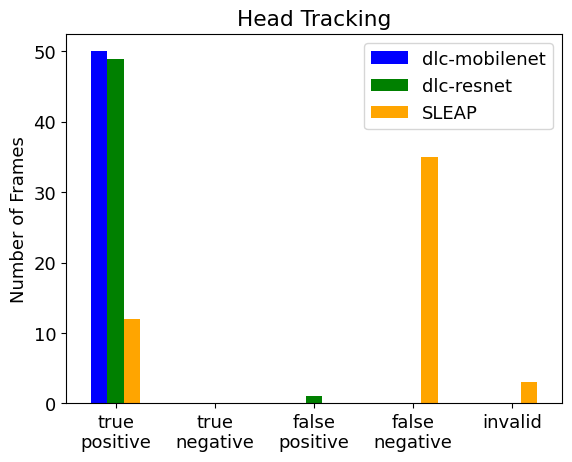

In [ ]:
# COMPILE AND PLOT HEAD DATA

mobilenet_head = list(dlc_mobilenet_ht['Head'])
resnet_head = list(dlc_resnet_ht['Head'])
sleap_head = list(df_ht['Head'])

index = ['true\npositive', 'true\nnegative', 'false\npositive', 'false\nnegative', 'invalid']

df_head = pd.DataFrame({'dlc-mobilenet': mobilenet_head,
                   'dlc-resnet': resnet_head,
                   'SLEAP': sleap_head}, index=index)

# df
# setting font size
plt.rcParams.update({'font.size': 13})

colors=['blue', 'green', 'orange']
ax = df_head.plot.bar(rot=0, color=colors)
ax.set_ylabel('Number of Frames')
ax.set_title('Head Tracking')

# Save figure to disk
model_name = "COMBINED_HEAD_TRACKING"
# plt.savefig("../Data/Paper/" + model_name + "_COLAB_" + str(x_threshold) + "_" + str(y_threshold) + "_" + str(accuracy_threshold) + ".eps")

plt.show()

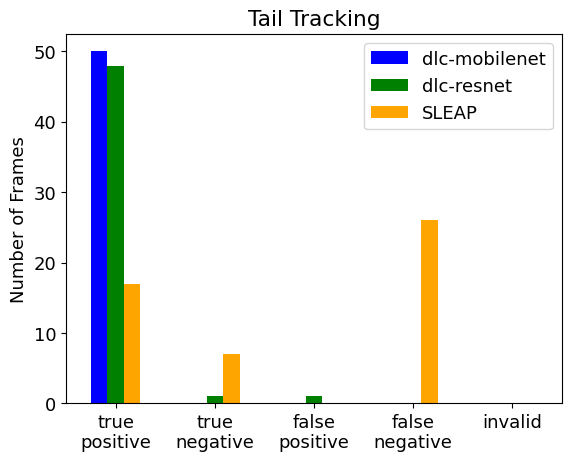

In [ ]:
# COMPILE AND PLOT TAIL DATA

mobilenet_tail = list(dlc_mobilenet_ht['Tail'])
resnet_tail = list(dlc_resnet_ht['Tail'])
sleap_tail = list(df_ht['Tail'])

index = ['true\npositive', 'true\nnegative', 'false\npositive', 'false\nnegative', 'invalid']

df_tail = pd.DataFrame({'dlc-mobilenet': mobilenet_tail,
                   'dlc-resnet': resnet_tail,
                   'SLEAP': sleap_tail}, index=index)

# df
# setting font size
plt.rcParams.update({'font.size': 13})

colors=['blue', 'green', 'orange']
ax = df_tail.plot.bar(rot=0, color=colors)
ax.set_ylabel('Number of Frames')
ax.set_title('Tail Tracking')

# Save figure to disk
model_name = "COMBINED_TAIL_TRACKING"
# plt.savefig("../Data/Paper/" + model_name + "_" + str(x_threshold) + "_COLAB_" + str(y_threshold) + "_" + str(accuracy_threshold) + ".eps")

plt.show()

In [ ]:
# COMPILE AND PLOT INFERENCE TIME DATA

mobilenet_it = list(dlc_mobilenet_it['Inference Time (seconds)'])
resnet_it = list(dlc_resnet_it['Inference Time (seconds)'])
frame_count = list(dlc_mobilenet_it['Unnamed: 0'])
# df_it

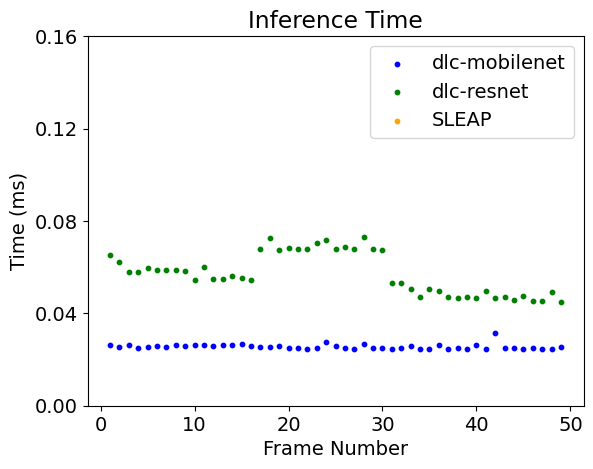

In [ ]:
# setting font size
plt.rcParams.update({'font.size': 14})

# fig = plt.figure(figsize=(12,11))
fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(frame_count[1:], mobilenet_it[1:], c='blue', s=10, label='dlc-mobilenet')
ax1.scatter(frame_count[1:], resnet_it[1:], c='green', s=10, label='dlc-resnet')
ax1.scatter(frame_count[1:], df_it[1:], c='orange', s=10, label='SLEAP')
ax1.set_ylabel('Time (ms)')
ax1.set_xlabel('Frame Number')
ax1.set_title('Inference Time')

ytick_loc = [0, 0.04, 0.08, 0.12, 0.16]
ax1.set_yticks(ytick_loc)

ax1.set_ylim((0, 0.16))

plt.legend(loc='best')

# Save figure to disk
model_name = "COMBINED_WIDER"
# plt.savefig("../Data/Paper/" + model_name + "_" + str(x_threshold) + "_COLAB_" + str(y_threshold) + "_" + str(accuracy_threshold) + ".eps")

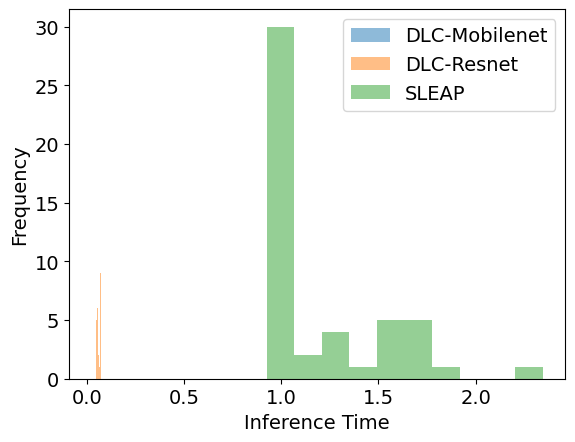

In [ ]:
# setting font size
plt.rcParams.update({'font.size': 14})

# fig = plt.figure(figsize=(12,11))
fig = plt.figure()

plt.hist(mobilenet_it[1:], alpha=0.5, label='DLC-Mobilenet', bins=10)
plt.hist(resnet_it[1:], alpha=0.5, label='DLC-Resnet', bins=10)
plt.hist(df_it[1:], alpha=0.5, label='SLEAP', bins=10)

plt.xlabel('Inference Time')
plt.ylabel('Frequency')
# plt.title('Histogram of Inference Times for Computer Vision Models')
plt.legend()

plt.show()

# Visualizing Inference

In [ ]:
# Predict on the entire video with parallelizable loading/preprocessing:
# predictions = predictor.predict(video)
# predictions

In [ ]:
# Visualize a frame.
# check_frame = 30
# predictions[manual_data['frame'][check_frame]].plot(scale=1)
# predictions[manual_data['frame'][check_frame]].instances

In [ ]:
# Inspect the contents of a single frame.
# labeled_frame = predictions[100]
# labeled_frame.instances

In [ ]:
# Convert an instance to a numpy array:
# labeled_frame[0].numpy()

In [ ]:
# for key, value in predictions.items():
#     print(f"'{key}': {value.shape} ({value.dtype})")